In [8]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from skimage import data, color, transform, feature
faces = fetch_lfw_people()
positive_patches = faces.images
print(positive_patches.shape)

(3185, 62, 47)


In [0]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
                      'page', 'clock', 'immunohistochemistry',
                      'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [6]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
        tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
print(negative_patches.shape)

(30000, 62, 47)


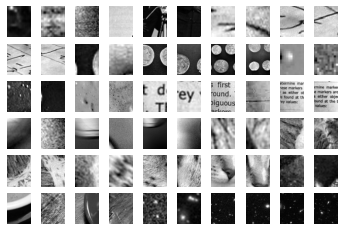

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')
plt.show()

In [34]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
print(X_train.shape)

(33185, 1215)


In [12]:
from sklearn.naive_bayes import GaussianNB       
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.96112702, 0.986741  , 0.98900105, 0.99261715, 0.98885038])

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9934910351062227

In [14]:
grid.best_params_

{'C': 1.0}

In [15]:
 model = grid.best_estimator_        
 model.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

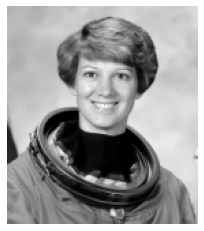

In [16]:
import skimage
test_image = skimage.data.astronaut()        
test_image = skimage.color.rgb2gray(test_image)        
test_image = skimage.transform.rescale(test_image, 0.5)        
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')        
plt.axis('off')
plt.show()

In [36]:
def sliding_window(img, 
                   patch_size=positive_patches[0].shape, 
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
      for j in range(0, img.shape[1] - Ni, jstep):
        patch = img[i:i + Ni, j:j + Nj]
        if scale != 1:
            patch = transform.resize(patch, patch_size)
        yield (i, j), patch
patches_hog.shape

(1911, 1215)

In [20]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [21]:
labels = model.predict(patches_hog)
labels.sum()


36.0

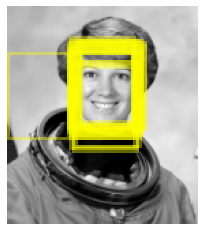

In [37]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:            
    ax.add_patch(plt.Rectangle((j, i), 
                               Nj, Ni, 
                               edgecolor='yellow',                                       
                              alpha=0.4, lw=3,                                       
                              facecolor='none'))
plt.show()
